In [1]:
pip install kafka-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\Alexis Mesias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [8]:
import random
import time
import json
from kafka import KafkaProducer

# CONFIGURACIÓN

BOOTSTRAP_SERVERS = ['iot.redesuvg.cloud:9092']
TOPIC = '22500'  

TEMP_MEDIA = 25.0      
TEMP_DESV = 10.0       
HUM_MEDIA = 60.0       
HUM_DESV = 15.0        

DIRECCIONES_VIENTO = ['N', 'NO', 'O', 'SO', 'S', 'SE', 'E', 'NE']


def generar_temperatura():
    valor = random.gauss(TEMP_MEDIA, TEMP_DESV)
    valor = max(0.0, min(110.0, valor))   
    return round(valor, 2)


def generar_humedad():
    valor = random.gauss(HUM_MEDIA, HUM_DESV)
    valor = max(0.0, min(100.0, valor))
    return int(round(valor))


def generar_direccion_viento():
    return random.choice(DIRECCIONES_VIENTO)


def generar_medicion():
    return {
        "temperatura": generar_temperatura(),
        "humedad": generar_humedad(),
        "direccion_viento": generar_direccion_viento()
    }


def main():
    producer = KafkaProducer(
        bootstrap_servers=BOOTSTRAP_SERVERS,
        value_serializer=lambda v: json.dumps(v).encode('utf-8'),
        key_serializer=lambda k: k.encode('utf-8') if isinstance(k, str) else k
    )

    print(f"Enviando datos al topic '{TOPIC}' en {BOOTSTRAP_SERVERS}...")
    print("Presiona Ctrl + C para detener.\n")

    try:
        while True:
            medicion = generar_medicion()
            print(f"Enviando: {medicion}")

            producer.send(
                TOPIC,
                key="sensor1",
                value=medicion
            )

            producer.flush()

            espera = random.randint(15, 30)
            print(f"Siguiente medición en {espera} segundos...\n")
            time.sleep(espera)

    except KeyboardInterrupt:
        print("Producer detenido por el usuario.")
    finally:
        producer.close()


if __name__ == "__main__":
    main()


Enviando datos al topic '22500' en ['iot.redesuvg.cloud:9092']...
Presiona Ctrl + C para detener.

Enviando: {'temperatura': 43.36, 'humedad': 59, 'direccion_viento': 'E'}
Siguiente medición en 15 segundos...

Enviando: {'temperatura': 24.16, 'humedad': 70, 'direccion_viento': 'N'}
Siguiente medición en 20 segundos...

Enviando: {'temperatura': 22.57, 'humedad': 72, 'direccion_viento': 'NO'}
Siguiente medición en 30 segundos...

Enviando: {'temperatura': 39.4, 'humedad': 78, 'direccion_viento': 'SE'}
Siguiente medición en 22 segundos...

Producer detenido por el usuario.


# 3.3 Consumir y Desplegar Datos Meteorológicos

Escuchando datos del topic '22500'...


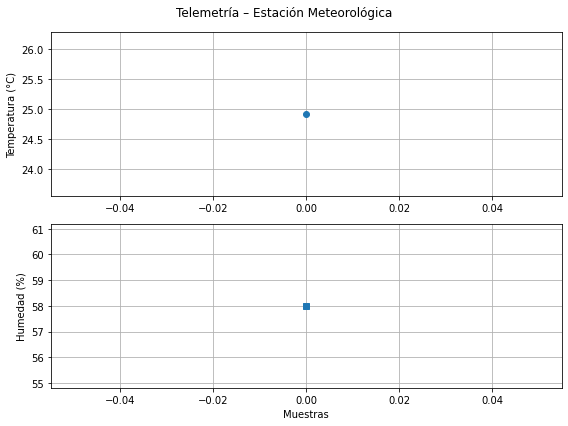

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

Consumer detenido por el usuario.


In [1]:
import json
from kafka import KafkaConsumer
import matplotlib.pyplot as plt

BOOTSTRAP_SERVERS = ['iot.redesuvg.cloud:9092']
TOPIC = '22500'

DIRECCIONES_VIENTO = ['N', 'NO', 'O', 'SO', 'S', 'SE', 'E', 'NE']

def main():
    consumer = KafkaConsumer(
    TOPIC,
    bootstrap_servers=BOOTSTRAP_SERVERS,
    value_deserializer=lambda v: json.loads(v.decode('utf-8')),
    key_deserializer=lambda k: k.decode('utf-8') if k else None,
    group_id='grupo_estacion_22500',
    auto_offset_reset='latest',
    enable_auto_commit=True,
    security_protocol='PLAINTEXT',
    request_timeout_ms=15000,
    session_timeout_ms=10000
)


    temps = []
    hums = []
    winds = []

    plt.ion()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle('Telemetría – Estación Meteorológica')

    try:
        print(f"Escuchando datos del topic '{TOPIC}'...")
        for msg in consumer:
            data = msg.value
            temp = data["temperatura"]
            hum = data["humedad"]
            wind = data["direccion_viento"]

            temps.append(temp)
            hums.append(hum)
            winds.append(wind)

            max_puntos = 50
            temps_plot = temps[-max_puntos:]
            hums_plot = hums[-max_puntos:]

            ax1.clear()
            ax1.plot(temps_plot, marker='o')
            ax1.set_ylabel('Temperatura (°C)')
            ax1.grid(True)

            ax2.clear()
            ax2.plot(hums_plot, marker='s')
            ax2.set_ylabel('Humedad (%)')
            ax2.set_xlabel('Muestras')
            ax2.grid(True)

            plt.tight_layout()
            plt.pause(0.01)

    except KeyboardInterrupt:
        print("Consumer detenido por el usuario.")
    finally:
        consumer.close()
        plt.ioff()
        plt.show()

if __name__ == "__main__":
    main()


## ¿Ventajas y desventajas del enfoque Pub/Sub de Kafka?

### Ventajas:

Desacopla fuertemente producers y consumers.

Escala muy bien con muchos clientes.

Puede procesar datos en tiempo real.

Garantiza orden por partición y tolerancia a fallos.

### Desventajas:

Requiere infraestructura adicional (cluster de Kafka).

Curva de aprendizaje más alta que una cola simple.

Puede ser “overkill” para sistemas pequeños.

## ¿Para qué aplicaciones tiene sentido usar Kafka? ¿Para cuáles no?

### Sí tiene sentido:

Telemetría IoT a gran escala.

Pipelines de datos y analítica en tiempo real.

Microservicios que comparten eventos.

Monitoreo de logs, métricas y eventos.

### No tiene tanto sentido:

Proyectos pequeños / prototipos sencillos.

Dispositivos muy limitados (batería, CPU, red) donde es mejor usar MQTT u otro protocolo ligero.

Casos donde unos pocos mensajes puntuales son suficientes.

# 3.4 IoT en Entornos con Restricciones

## Utilidades

In [ ]:
import random

# ==== CONFIGURACIÓN GENERAL ====

BOOTSTRAP_SERVERS = ['iot.redesuvg.cloud:9092']
TOPIC = '22500'

TEMP_MEDIA = 25.0
TEMP_DESV = 10.0
HUM_MEDIA = 60.0
HUM_DESV = 15.0

DIRECCIONES_VIENTO = ['N', 'NO', 'O', 'SO', 'S', 'SE', 'E', 'NE']

WIND_TO_INT = {
    'N': 0,
    'NO': 1,
    'O': 2,
    'SO': 3,
    'S': 4,
    'SE': 5,
    'E': 6,
    'NE': 7
}

INT_TO_WIND = {v: k for k, v in WIND_TO_INT.items()}


def generar_temperatura():
    valor = random.gauss(TEMP_MEDIA, TEMP_DESV)
    valor = max(0.0, min(110.0, valor))
    return round(valor, 2)


def generar_humedad():
    valor = random.gauss(HUM_MEDIA, HUM_DESV)
    valor = max(0.0, min(100.0, valor))
    return int(round(valor))


def generar_direccion_viento():
    return random.choice(DIRECCIONES_VIENTO)


def generar_medicion():
    return {
        "temperatura": generar_temperatura(),
        "humedad": generar_humedad(),
        "direccion_viento": generar_direccion_viento()
    }


def encode_medicion_3bytes(medicion: dict) -> bytes:
    temp = medicion["temperatura"]
    hum = medicion["humedad"]
    wind = medicion["direccion_viento"]

    temp_int = int(round(temp * 100))
    hum_int = int(hum)
    wind_int = WIND_TO_INT[wind]

    temp_int = max(0, min(11000, temp_int))
    hum_int = max(0, min(100, hum_int))
    wind_int = max(0, min(7, wind_int))

    packed = (temp_int << 10) | (hum_int << 3) | wind_int

    return packed.to_bytes(3, byteorder='big')


def decode_medicion_3bytes(payload: bytes) -> dict:
    """
    Toma 3 bytes y regresa el dict:
    {
        "temperatura": float,
        "humedad": int,
        "direccion_viento": str
    }
    """
    packed = int.from_bytes(payload, byteorder='big')

    wind_int = packed & 0b111
    hum_int = (packed >> 3) & 0b1111111
    temp_int = packed >> 10

    temp = temp_int / 100.0
    wind = INT_TO_WIND[wind_int]

    return {
        "temperatura": temp,
        "humedad": hum_int,
        "direccion_viento": wind
    }


## Consumer

In [ ]:
from kafka import KafkaConsumer
import matplotlib.pyplot as plt

def main():
    consumer = KafkaConsumer(
        TOPIC,
        bootstrap_servers=BOOTSTRAP_SERVERS,
        value_deserializer=lambda v: v,
        key_deserializer=lambda k: k.decode('utf-8') if k else None,
        group_id='grupo_estacion_22500_payload3bytes',
        auto_offset_reset='latest',
        enable_auto_commit=True
    )

    temps = []
    hums = []

    plt.ion()
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
    fig.suptitle('Telemetría – Payload de 3 bytes')

    try:
        print(f"Escuchando datos codificados en 3 bytes del topic '{TOPIC}'...")
        for i, msg in enumerate(consumer, start=1):
            medicion = decode_medicion_3bytes(msg.value)

            temp = medicion["temperatura"]
            hum = medicion["humedad"]

            print(f"[{i}] Medición decodificada: {medicion}")

            temps.append(temp)
            hums.append(hum)

            max_puntos = 50
            temps_plot = temps[-max_puntos:]
            hums_plot = hums[-max_puntos:]

            ax1.clear()
            ax1.plot(range(len(temps_plot)), temps_plot, marker='o')
            ax1.set_ylabel('Temperatura (°C)')
            ax1.grid(True)

            ax2.clear()
            ax2.plot(range(len(hums_plot)), hums_plot, marker='s')
            ax2.set_ylabel('Humedad (%)')
            ax2.set_xlabel('Muestras')
            ax2.grid(True)

            plt.tight_layout()
            plt.pause(0.01)

    except KeyboardInterrupt:
        print("Consumer 3.4 detenido por el usuario.")
    finally:
        consumer.close()
        plt.ioff()

if __name__ == "__main__":
    main()


## Producer

In [ ]:
import time
from kafka import KafkaProducer
import random

def main():
    producer = KafkaProducer(
        bootstrap_servers=BOOTSTRAP_SERVERS,
        value_serializer=lambda v: v,
        key_serializer=lambda k: k.encode('utf-8') if isinstance(k, str) else k
    )

    print(f"Enviando datos *codificados en 3 bytes* al topic '{TOPIC}'...")
    print("Presiona Ctrl + C para detener.\n")

    try:
        while True:
            medicion = generar_medicion()
            payload = encode_medicion_3bytes(medicion)

            print(f"Medición original: {medicion}")
            print(f"Payload (hex): {payload.hex()}\n")

            producer.send(
                TOPIC,
                key="sensor1",
                value=payload
            )
            producer.flush()

            espera = random.randint(15, 30)
            print(f"Siguiente medición en {espera} segundos...\n")
            time.sleep(espera)

    except KeyboardInterrupt:
        print("Producer 3.4 detenido por el usuario.")
    finally:
        producer.close()


if __name__ == "__main__":
    main()


### ¿Qué complejidades introduce un payload tan pequeño (3 bytes)?

Hay que cuantizar y perder precisión (especialmente en floats).

Se debe diseñar un protocolo bit a bit propio.

Se complica la implementación (encode/decode manual).

Menos flexibilidad para agregar nuevos campos sin romper compatibilidad.

### ¿Cómo hacer que la temperatura quepa en 14 bits?

Usando representación en punto fijo: multiplicar la temperatura por un factor (por ejemplo 100) y guardarla como entero.

Así 56.32°C → 5632, que cabe en 14 bits (máx 16383).

### ¿Qué pasaría si la humedad también fuera float con un decimal?

Requeriría más bits (ej. 0–100.0 → 0–1000 si multiplicas por 10).

Habría que:

Quitar precisión (usar enteros), o

Quitar precisión de temperatura, o

Cambiar el layout de bits o aumentar el tamaño de payload (si fuera posible).

### ¿Qué parámetros/herramientas de Kafka ayudarían si las restricciones fueran aún más fuertes?

Compresión de mensajes (gzip, snappy, lz4, zstd).

Batching de mensajes para amortizar overhead.

Ajustar acks, linger.ms, batch.size para reducir metadata y overhead por mensaje.

Usar valores binarios compactos (bytes) en lugar de JSON.